<a href="https://colab.research.google.com/github/DoubleCyclone/Neural-Network-From-Scratch/blob/main/notebooks/Neural_Network_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Introduction & Setup
As a Machine Learning student (self-proclaimed), I am learning how to build and use various models. In this notebook specifically, I will create my own Neural Network from Scratch with **Numpy**. After that, I will create an identical model with **PyTorch** and compare them.

I will be using the [**MNIST**](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) dataset to train the model and run predictions.

Let's import the packages first.

In [1]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import time

At first I have to load the **MNIST** datasets (Train / Test). While doing that, let's print out their shapes to learn a little more about them.


In [2]:
# Load the MNIST dataset with the specified transformation
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Convert datasets to Numpy arrays
X_train_full = mnist_train.data.numpy()  #(60000, 28, 28)
y_train_full = mnist_train.targets.numpy()  # (60000,)
X_test = mnist_test.data.numpy()  # (10000, 28, 28)
y_test = mnist_test.targets.numpy()  # (10000,)

print(f"Full training data: {X_train_full.shape}")
print(f"Full training labels: {y_train_full.shape}")
print(f"Test data: {X_test.shape}")
print(f"Test labels: {y_test.shape}")

Full training data: (60000, 28, 28)
Full training labels: (60000,)
Test data: (10000, 28, 28)
Test labels: (10000,)


There are 60000 images in the training set and 10000 in the test set and the images are of 28x28 size. Now let's plot a few of them with their labels as visualization is of utmost importance especially when learning.

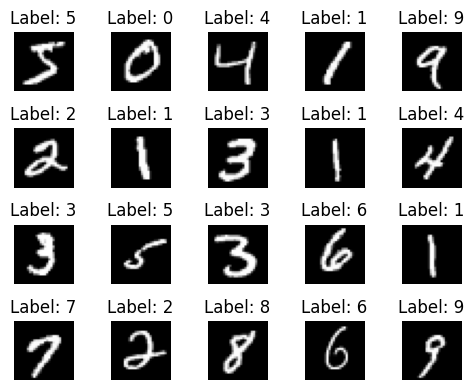

In [3]:
# Create a figure to display the images
fig, axs = plt.subplots(4, 5 , figsize=(5, 4))

# Flatten to iterate easily
axs = axs.flatten()

# For every sample in the training set
for i, data in enumerate(X_train_full):
    # Plot it (until the 20th)
    if i < 20:
        axs[i].imshow(X_train_full[i].squeeze(), cmap='gray') # Show the image
        axs[i].set_title(f"Label: {y_train_full[i]}") # Set the label as the title
        axs[i].axis('off') # Turn off axis to make the image cleaner
    else:
        break  # Exit the loop after printing 20 samples

# Fix overlap and show the plot
fig.tight_layout()
fig.show()

What about checking how one example looks in numerical form? (Click on the show data button in the output)

In [4]:
X_train_full[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
        253, 253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253, 253,
        253, 253, 253, 253, 251,  93,  82,  82,  56,  39,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253, 253, 253, 253,
        253, 198, 182, 247, 241,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156, 107, 253, 253,
        205,  11,   0,  43, 154,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253,
         90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 139, 253,
        190,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 190,
        253,  70,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35,
        241, 225, 160, 108,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         81, 240, 253, 253, 119,  25,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  45, 186, 253, 253, 150,  27,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  16,  93, 252, 253, 187,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 249, 253, 249,  64,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  46, 130, 183, 253, 253, 207,   2,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  39,
        148, 229, 253, 253, 253, 250, 182,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  24, 114, 221,
        253, 253, 253, 253, 201,  78,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  23,  66, 213, 253, 253,
        253, 253, 198,  81,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  18, 171, 219, 253, 253, 253, 253,
        195,  80,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  55, 172, 226, 253, 253, 253, 253, 244, 133,
         11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 136, 253, 25

Seems like the background (black) is encoded as 0 and the foreground as greater than 0 (white/whiteish) where it gets closer to white the further away the value gets from 0.

For our handmade Neural Network, I will set up just one hidden layer. Output node count has to be equal to the class count which is 10 (numbers from 0 to 9). Input node count has to be equal to the image size which is 28 x 28 = 784 pixels.

# 2 - Building Mathematical Components
As activation functions, I will be using **ReLU** (Rectified Linear Unit) for hidden layers as it helps with vanishing gradient problem and **Softmax** for the output layer so that their probabilities' sum will be equal to 1 (100%). Let's start by implementing **ReLU** and plotting it.

In [5]:
# Relu function
def relu(x : float) :
  return np.maximum(0, x)

Let's also create a simple plotting function to easily visualize our implemented functions.

In [6]:
def plot_func(func, x) :
  # plot x versus y (func(x))
  plt.plot(x, [func(val) for val in x])
  plt.xlabel("x")
  plt.ylabel("Function")
  plt.show()

Now let's visualize to check if the function is correct.

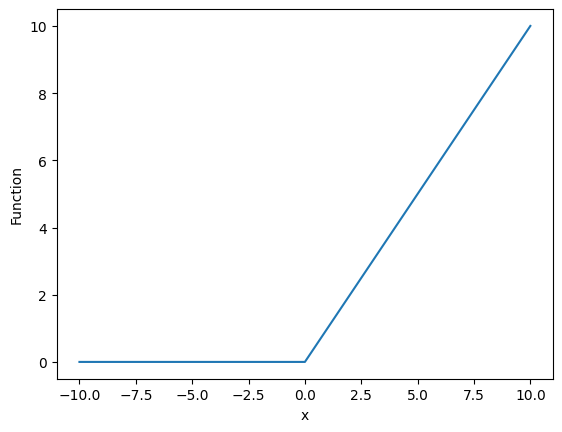

In [7]:
# decide on some x values for plotting
x = [i for i in range(-10, 11, 1)]

plot_func(relu, x)

I will have to implement the derivatives of these functions as they will be needed later on.

In [8]:
def d_relu(x) :
  return x > 0

Visualize this one as well.

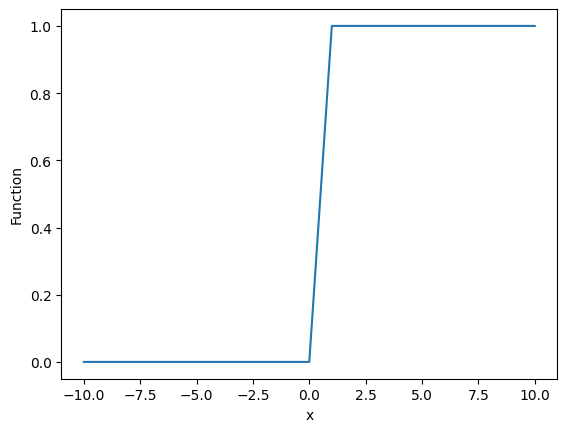

In [9]:
plot_func(d_relu, x)

Now I will implement the **Softmax** function.

In [10]:
def softmax(logits) :
  exp_logits = np.exp(logits - np.max(logits, axis=-1, keepdims=True))
  return exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)

In [11]:
# Create a simple vector for testing
vector = [1, 3, 2]

# Test the function
print(softmax(vector))

[0.09003057 0.66524096 0.24472847]


Seems like the softmax function is working as intended as well. For a model to evaluate how much error it has, we need a **Loss Function**. As this is a multiclass classification task, I can use something called a **Categorical Cross-entropy loss**. It measures the difference between the predicted probability distribution and the true one-hot encoded labels, penalizing the model when confidence is low on the correct class. Now let's implement it.

In [12]:
def categorical_cross_entropy(pred_labels, true_labels):
    # A very small number to avoid division by zero
    epsilon = 1e-9
    # Clip values into a range of
    pred_labels = np.clip(pred_labels, epsilon, 1 - epsilon)
    # This is just the formula...
    return -np.sum(true_labels * np.log(pred_labels))

Now let's test the function with dummy values. Note that our loss function requires one-hot encoded labels so the dummy will be written accordingly.

In [13]:
true_label = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0] )# Example one-hot encoding for class 4, length 10 for MNIST
preds = softmax(np.random.rand(10)) # Generate 10 random logits for 10 classes

# Has to be 1 (floating point precision problem may make this 0.99999999 or 1.00000002 or similar which is okay)
print(np.sum(preds))

print(categorical_cross_entropy(preds, true_label))

1.0
2.428540251549061


Now for the derivative of the cross-entropy. As the loss function will take predictions that come from **Softmax**, their combined derivative conveniently have a really simple formula.

In [14]:
def d_categorical_cross_entropy(pred_labels, true_labels) :
  return pred_labels - true_labels

Let's test with dummy data.

In [15]:
print(d_categorical_cross_entropy(np.asarray([0.15, 0.4, 0.46]), np.asarray([1, 0, 0])))

[-0.85  0.4   0.46]


Now that our functions are ready, I can start building some matrices so that they form a neural network. For weights, there are a few initialization strategies like **Xavier Initialization** and **He Initialization**. First one is more suitable for layers that use **TANH** or **Sigmoid** activation functions whereas the second one is better when paired with **ReLU** activation function.

To decide on the size of our only hidden layer, I will follow a few rule-of-thumb methods:
1. The number of hidden neurons should be between the size of the input layer and the size of the output layer.
2. The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.
3. The number of hidden neurons should be less than twice the size of the input layer.

So if I were to follow the second rule, the hidden layer should have 533 (532,6 rounded up) nodes. Now let's build the layers.

In [16]:
# Calculate total nodes on each layer
input_node_count = X_train_full[0].shape[0] * X_train_full[0].shape[1] # first example's dimensions multiplied (28 x 28)
output_node_count = len(np.unique(y_train_full)) # unique class count in the dataset (10)
hidden_node_count = np.ceil((input_node_count * 2 / 3) + output_node_count).astype(int) # rule of thumb formula

# Initialize node weights with He Initialization strategy
input_hidden_weights = np.random.randn(input_node_count, hidden_node_count) * np.sqrt(2 / input_node_count)
hidden_output_weights = np.random.randn(hidden_node_count, output_node_count) * np.sqrt(2 / hidden_node_count)

# Initialize node biases to zero (often done this way)
hidden_biases = np.zeros(shape=(hidden_node_count))
output_biases = np.zeros(shape=(output_node_count))

print(f"Input-Hidden Layer weights amount : {input_hidden_weights.shape}")
print(f"Hidden-Output Layer weights amount : {hidden_output_weights.shape}")
print(f"Hidden biases Layer amount : {hidden_biases.shape}")
print(f"Output biases Layer amount : {output_biases.shape}")

Input-Hidden Layer weights amount : (784, 533)
Hidden-Output Layer weights amount : (533, 10)
Hidden biases Layer amount : (533,)
Output biases Layer amount : (10,)


# 3 - Forward Propagation
Now that our layers are ready, it is time to combine them so that they can perform a single forward pass. But before that, I will scale the data so that the range of brightness is reduced from 0-255 to 0-1 as it is infinitely more manageable to work with smaller numbers. I can do this by adding a **Normalization Layer** before any weights or biases are applied. I will also implement One-Hot encoding for labels. This converts class labels (like 5) into binary vectors (like [0,0,0,0,0,1,0,0,0,0]), which is needed for calculating categorical cross-entropy loss with our NumPy model.

In [17]:
def apply_normalization(data):
    # If it's a single image (28x28), reshape to (1, 784)
    # If it's a batch (Batch, 28, 28), reshape to (Batch, 784)
    reshaped_data = data.reshape(data.shape[0] if data.ndim > 2 else 1, -1)
    # Scale the data by dividing the value by 255 (max value)
    return reshaped_data / 255

In [18]:
def apply_one_hot_encoding(labels) :
  # Shape the new labels with rows equal to old labels but cols equal to output node count (old_labels, 10)
  oh_encoded = np.empty(shape=(len(labels), output_node_count))
  for i, row in enumerate(oh_encoded) :
    # set all cells to 0 and only the label cell to 1
    oh_encoded[i] = 0
    oh_encoded[i, labels[i]] = 1
  return oh_encoded

In [19]:
def reverse_one_hot_encoding(labels) :
  # Find the index of the 1 in each one-hot encoded vector
  reversed_labels = np.argmax(labels, axis=1)
  return reversed_labels

After this normalization, I will multiply all the neurons in the input layer by the weights that were initialized earlier.

In [20]:
def apply_weights(data, weights):
    return np.dot(data, weights)

Then the biases will be added to the outputs from the weight multiplication.

In [21]:
def apply_biases(data, biases):
    return data + biases

After that, the activation function (ReLU) will be applied to the outputs so that the values are 0 or greater than 0. Lastly, Softmax will be applied so that the logits will be turned into meaningful predictions that sum up to 1. I already implemented ReLU and Softmax earlier so let's just add them all together for a single forward pass.

In [22]:
def single_forward(data, weights_1, biases_1, weights_2, biases_2):
    # Normalize the data (scale)
    input_layer = apply_normalization(data)

    # Multiply by the weights and add the biases from input to hidden layer
    z1 = apply_biases(apply_weights(input_layer, weights_1), biases_1)
    # Apply the activation function
    a1 = relu(z1)

    # Multiply by the weights and add the biases from hidden to output layer
    z2 = apply_biases(apply_weights(a1, weights_2), biases_2)
    # Apply softmax to turn logits into predictions
    a2 = softmax(z2)

    # Create a dictionary to store the values (will be needed later)
    cache = {
        'input': input_layer,
        'z1': z1,
        'a1': a1,
        'z2': z2,
        'a2' : a2
    }

    return a2, cache

Let's test the forward pass on just one example and see if the outputs make sense.

In [23]:
# Perform a single forward pass
preds, cache = single_forward(X_train_full[0], input_hidden_weights, hidden_biases, hidden_output_weights, output_biases)

# One-Hot Encode the first label for testing
true_label_one_hot = apply_one_hot_encoding([y_train_full[0]])

# Calculate the loss
loss = categorical_cross_entropy(preds, true_label_one_hot)

print(f"Predicted class : {np.argmax(preds)}")
print(f"Prediction values : {preds.flatten()}")
print(f"Sum of predictions : {preds.sum()}")
print(f"Loss : {loss}")

Predicted class : 7
Prediction values : [0.07577163 0.112938   0.11086654 0.08723919 0.11648295 0.07454623
 0.07296457 0.12934646 0.10237722 0.1174672 ]
Sum of predictions : 0.9999999999999999
Loss : 2.596335755657095


As can be seen from the sum and the values themselves, they sum up to 1 which was exactly what was needed. Note that currently as the model is not being trained at all (only random initialization), its predictions are random.
# 4 - Backward propagation
To be able to train the model, I need to implement something called "**Backward Propagation**" which is the process of calculating how much each weight and bias should change with respect to the current error of the prediction. For this, I need to implement the derivatives of the weights and biases on the layers with respect to the ones in the previous layers. Naturally, we start from the end which is why it is called **Backward propagation**. Fortunately the **Softmax** function and the **Cross-Entropy Loss** functions' derivatives cancel out most calculations, leaving only "predictions - true labels" for us to calculate for the first step.

In the next step, I need to calculate how much the weights between the hidden-output layers contribute to the losses so that we can increase/decrease their values accordingly. For this, we need the gradient from the latest step and the input to the layer. With these, we calculate the outer product of them so that we end up with same amount of gradients as the weight count.

Then we propagate error back to the hidden layer on which the ReLU derivative will be applied to check if the neurons were active or inactive.

From there, the same gradient after the ReLU derivative will be applied to the biases on the hidden layer as they are directly proportionate to the value after the activation.

Lastly, for the weights between the Input-Hidden layer, that same relu derivative applied gradient will be used to calculate the gradients along with the cached input values.

In [24]:
def single_backward(cache, true_labels, weights_2):
    # Determine the number of samples in the current batch
    sample_count = true_labels.shape[0]

    # Gradient at output (predictions - true_labels)
    dL_dz2 = d_categorical_cross_entropy(cache['a2'], true_labels)

    # Gradients for second layer (averaged over batch)
    # Using .T (transpose) and np.dot performs the accumulation and averaging automatically
    dL_dbiases2 = np.sum(dL_dz2, axis=0) / sample_count
    dL_dweights2 = np.dot(cache['a1'].T, dL_dz2) / sample_count

    # Propagate error back to hidden layer
    dL_da1 = np.dot(dL_dz2, weights_2.T)

    # Apply ReLU derivative
    dL_dz1 = dL_da1 * d_relu(cache['z1'])

    # Gradients for first layer (averaged over batch)
    dL_dbiases1 = np.sum(dL_dz1, axis=0) / sample_count
    dL_dweights1 = np.dot(cache['input'].T, dL_dz1) / sample_count

    return {
        'dL_dweights1': dL_dweights1,
        'dL_dbiases1': dL_dbiases1,
        'dL_dweights2': dL_dweights2,
        'dL_dbiases2': dL_dbiases2
    }

In [25]:
gradients = single_backward(cache, apply_one_hot_encoding([y_train_full[0]]), hidden_output_weights)

print(gradients['dL_dbiases1'])

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.05325637e-01
 -4.06883611e-02  0.00000000e+00  0.00000000e+00 -2.17445530e-02
  0.00000000e+00  0.00000000e+00 -6.87751392e-02  0.00000000e+00
 -1.24976636e-02  0.00000000e+00  8.59202539e-03  2.92989005e-02
  0.00000000e+00  3.18401710e-02  0.00000000e+00  5.38398181e-02
  6.93560075e-04  6.09848485e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  4.66618106e-02  0.00000000e+00  0.00000000e+00
 -5.35142474e-02 -2.54513893e-02  0.00000000e+00  1.15187762e-01
  6.91019528e-02  0.00000000e+00  1.75250188e-02 -7.85198474e-02
  0.00000000e+00  0.00000000e+00 -5.35805588e-02  6.23648792e-02
  4.24031671e-02 -1.25935359e-01  1.82631337e-02  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -7.04019969e-02 -9.07063297e-02
  0.00000000e+00  1.20908296e-01  0.00000000e+00  0.00000000e+00
 -4.74930123e-02 -6.46169321e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.65734437e-02  0.00000000e+00
  0.00000000e+00  0.00000

# 5 - Training Loop
After calculating these gradients, I will update the weights/biases in the network so that the next forward pass will yield better results. As I already have implemented the forward pass and backward propagation, the next thing we need will be deciding on some **Hyperparameters** like **Learning Rate** so that we can amplify how much the gradients affect our model parameters with each pass.

Also, it is often better to run the gradient descent on mini-batches instead of after every sample. This is done by splitting the data into smaller chunks and running gradient descent after each chunk has been processed instead which is computationally cheaper.

I also will split the training set into training and validation sets to evaluate the model on data that weren't used to train the model which gives us an idea on how the model performs on generalization instead of memorization.

In [26]:
# Split training data into train and validation sets (test is already set up)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.16666, random_state=42
)

print(f"\nAfter split:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


After split:
X_train: (50000, 28, 28), y_train: (50000,)
X_val: (10000, 28, 28), y_val: (10000,)
X_test: (10000, 28, 28), y_test: (10000,)


Now it is time to build the Model class.

In [27]:
class Model() :
  def __init__(self, input_node_count, hidden_node_count, output_node_count) :
    # Initialize node weights
    self.w1 = np.random.randn(input_node_count, hidden_node_count) * np.sqrt(2 / input_node_count)
    self.w2 = np.random.randn(hidden_node_count, output_node_count) * np.sqrt(2 / hidden_node_count)
    # Initialize node biases
    self.b1 = np.zeros(shape=(hidden_node_count))
    self.b2 = np.zeros(shape=(output_node_count))
    # To store losses
    self.train_losses = []
    self.val_losses = []
    # To store metrics
    self.metrics = {}
    self.metrics['accuracy'], self.metrics['precision'], self.metrics['recall'], self.metrics['f1'] = [], [], [], []

  # Call forward pass
  def __forward(self, data) :
    return single_forward(data, self.w1, self.b1, self.w2, self.b2)

  # Call backward propagation
  def __backward(self, cache, true_labels) :
    return single_backward(cache, true_labels, self.w2)

  # Update weights with respect to the gradients and learning rate
  def __update_weights(self, gradients, learning_rate) :
    self.w1 -= gradients['dL_dweights1'] * learning_rate
    self.b1 -= gradients['dL_dbiases1'] * learning_rate
    self.w2 -= gradients['dL_dweights2'] * learning_rate
    self.b2 -= gradients['dL_dbiases2'] * learning_rate

  def predict(self, X_test, compare = False, true_labels = None):
    # Pass the entire dataset X through the forward pass at once
    pred_probs, _ = self.__forward(X_test)

    # Use axis=1 to find the highest probability for each individual image
    preds = np.argmax(pred_probs, axis=1)

    # Initialize empty metrics dict
    metrics = {}

    # Calculate and store metrics if comparison is turned on
    if compare :
      # Determine if true_labels are already in 1D integer format or one-hot encoded
      if true_labels.ndim > 1: # If it's 2D (one-hot encoded), then reverse it
        true_labels_for_metrics = reverse_one_hot_encoding(true_labels)
      else: # If it's already 1D (integer labels), use it directly
        true_labels_for_metrics = true_labels

      # Calculate metrics
      metrics['accuracy'] = accuracy_score(true_labels_for_metrics, preds)
      metrics['precision'] = precision_score(true_labels_for_metrics, preds, average='weighted', zero_division=0)
      metrics['recall'] = recall_score(true_labels_for_metrics, preds, average='weighted', zero_division=0)
      metrics['f1'] = f1_score(true_labels_for_metrics, preds, average='weighted', zero_division=0)

    return preds, metrics

  def predict_single(self, ax, x, y) :
    # Run forward pass on a sample
    predictions, _ = self.__forward(x)
    # Take the highest prediction value
    pred_label = np.argmax(predictions, axis=1)
    confidence_score = np.max(predictions)
    # Show the image along with the predictions
    ax.imshow(x.squeeze(), cmap='gray')
    ax.set_title(f"True : {y} | Pred : {pred_label[0]} Conf : {confidence_score:.4f}")
    ax.axis('off')

  def train(self, epochs, batch_size, learning_rate, X_train, y_train, val = False, X_val = None, y_val = None) :
    # For every epoch
    for epoch in range(epochs):
      # Shuffle the training set to prevent order bias
      X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train)
      # Calculate number of batches
      num_batches = len(X_train_shuffled) // batch_size
      # Reset epoch loss
      epoch_loss = 0

      # For every batch
      for batch_idx in range(num_batches):
        # Calculate batch start and end indices
        batch_start = batch_idx * batch_size
        batch_end = batch_start + batch_size

        # Slice dataset accordingly
        X_batch = X_train_shuffled[batch_start:batch_end]
        y_batch = y_train_shuffled[batch_start:batch_end]

        # Run forward pass (with softmax)
        predictions, cache = self.__forward(X_batch)

        # Divide by batch_size to get the average loss for this batch
        batch_loss = categorical_cross_entropy(predictions, y_batch) / batch_size
        epoch_loss += batch_loss

        # Perform back propagation
        gradients = self.__backward(cache, y_batch)
        # Update weights and biases
        self.__update_weights(gradients, learning_rate)

      # Record epoch loss
      self.train_losses.append(epoch_loss / num_batches)

      # Track validation loss
      val_loss = 0

      # Validation Loop
      if val:
        # Run forward pass on validation set
        val_predictions, _ = self.__forward(X_val)
        # Calculate total validation loss and divide by the number of validation samples
        self.val_losses.append(categorical_cross_entropy(val_predictions, y_val) / X_val.shape[0])

        if y_val.ndim > 1: # If it's 2D (one-hot encoded), then reverse it
          true_preds = reverse_one_hot_encoding(y_val)

        # Turn preds into labels
        val_predictions = np.argmax(val_predictions, axis=1)

        self.metrics['accuracy'].append(accuracy_score(true_preds, val_predictions))
        self.metrics['precision'].append(precision_score(true_preds, val_predictions, average='weighted', zero_division=0))
        self.metrics['recall'].append(recall_score(true_preds, val_predictions, average='weighted', zero_division=0))
        self.metrics['f1'].append(f1_score(true_preds, val_predictions, average='weighted', zero_division=0))

        # Print validation progress with all metrics
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {self.train_losses[epoch]:.4f}, Val Loss: {self.val_losses[epoch]:.4f}, Acc: {self.metrics['accuracy'][epoch]:.4f}, Prec: {self.metrics['precision'][epoch]:.4f}, Rec: {self.metrics['recall'][epoch]:.4f}, F1: {self.metrics['f1'][epoch]:.4f}")
      else :
        # Print training progress
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {self.train_losses[epoch]:.4f}")

# 6 - Training and Evaluation
Now that our model class is ready with its training function. It is time to train it and see how it performs.

In [28]:
# Initialize the model
model_np = Model(input_node_count, hidden_node_count, output_node_count)

# Convert labels to one-hot for NumPy model
y_train_oh = apply_one_hot_encoding(y_train)
y_val_oh = apply_one_hot_encoding(y_val)
y_test_oh = apply_one_hot_encoding(y_test)

start_time_np = time.perf_counter()
# Run the training loop
model_np.train(
    epochs=20,
    batch_size=64,
    learning_rate=0.01,
    X_train=X_train,
    y_train=y_train_oh,
    val=True,
    X_val=X_val,
    y_val=y_val_oh
)
end_time_np = time.perf_counter()

duration_np = end_time_np - start_time_np
minutes_np = int(duration_np // 60)
seconds_np = int(duration_np % 60)
np_train_time_var = f"{minutes_np}m {seconds_np}s"
print(f"NumPy Model Training Wall time: {np_train_time_var}")

Epoch 1/20, Train Loss: 0.8688, Val Loss: 0.4783, Acc: 0.8767, Prec: 0.8765, Rec: 0.8767, F1: 0.8763
Epoch 2/20, Train Loss: 0.4143, Val Loss: 0.3684, Acc: 0.9014, Prec: 0.9011, Rec: 0.9014, F1: 0.9011
Epoch 3/20, Train Loss: 0.3467, Val Loss: 0.3241, Acc: 0.9107, Prec: 0.9107, Rec: 0.9107, F1: 0.9105
Epoch 4/20, Train Loss: 0.3123, Val Loss: 0.2974, Acc: 0.9166, Prec: 0.9166, Rec: 0.9166, F1: 0.9165
Epoch 5/20, Train Loss: 0.2890, Val Loss: 0.2777, Acc: 0.9225, Prec: 0.9224, Rec: 0.9225, F1: 0.9223
Epoch 6/20, Train Loss: 0.2712, Val Loss: 0.2626, Acc: 0.9261, Prec: 0.9262, Rec: 0.9261, F1: 0.9260
Epoch 7/20, Train Loss: 0.2566, Val Loss: 0.2496, Acc: 0.9296, Prec: 0.9296, Rec: 0.9296, F1: 0.9295
Epoch 8/20, Train Loss: 0.2440, Val Loss: 0.2394, Acc: 0.9324, Prec: 0.9325, Rec: 0.9324, F1: 0.9324
Epoch 9/20, Train Loss: 0.2332, Val Loss: 0.2294, Acc: 0.9344, Prec: 0.9343, Rec: 0.9344, F1: 0.9343
Epoch 10/20, Train Loss: 0.2233, Val Loss: 0.2217, Acc: 0.9362, Prec: 0.9363, Rec: 0.9362, 

Our model's performance on the validation set is obviously worse than the one on the training set but it is definitely comparable which is great news. Now for a real evaluation I have to test it on the held-out test set which we haven't used before. For this I just have to call the predict function of the model class and visualize its predictions along with a few records from the test dataset loader.

It should be noted that the model has better validation loss at first than its train loss because the first validation loop is done after the first training loop where the model already has learnt significantly, boosting the performance on the validation.

In [29]:
# Run prediction on the test data
test_preds, metrics = model_np.predict(X_test, True, y_test)

# Print metrics
for key, value in metrics.items() :
  print(f"{key} : {value:.4f}")

accuracy : 0.9553
precision : 0.9553
recall : 0.9553
f1 : 0.9553


Performance looks great even on the test data. Now let's plot the Training/Validation losses over epochs for a better visual representation.

In [30]:
def plot_losses(train_losses, val_losses) :
  # Plot both train and val losses on the same graph
  x_range = range(1, len(train_losses) + 1)
  plt.plot(x_range, train_losses, label="Train Losses")
  plt.plot(x_range, val_losses, label="Val Losses")
  plt.xticks(range(1, len(train_losses) + 1, 1)) # Set x-axis ticks
  plt.ylim(np.min([np.min(train_losses), np.min(val_losses)]), np.max([np.max(train_losses), np.max(val_losses)])) # Set y-axis
  plt.legend()
  plt.show()

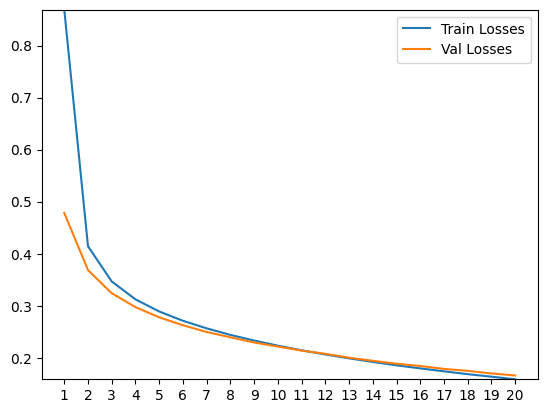

In [31]:
plot_losses(model_np.train_losses, model_np.val_losses)

Looks perfectly fine, now let's plot the metrics as well.

In [32]:
def plot_metrics(metrics) :
  # Create a composite plot
  fig, axs = plt.subplots(2, 2, figsize=(10,10))
  # Flatten for easier iterations
  axs = axs.flatten()

  x_range = range(1, len(metrics['accuracy']) + 1)

  axs[0].plot(x_range, metrics['accuracy'])
  axs[0].set_title('Accuracy')
  axs[1].plot(x_range, metrics['precision'])
  axs[1].set_title('Precision')
  axs[2].plot(x_range, metrics['recall'])
  axs[2].set_title('Recall')
  axs[3].plot(x_range, metrics['f1'])
  axs[3].set_title('F1')

  # set x to 0-20
  for ax in axs :
    ax.xaxis.set_ticks(range(1, len(metrics['accuracy']) + 1, 1))

  # fix overlap
  fig.tight_layout()
  # Show the plots
  fig.show()

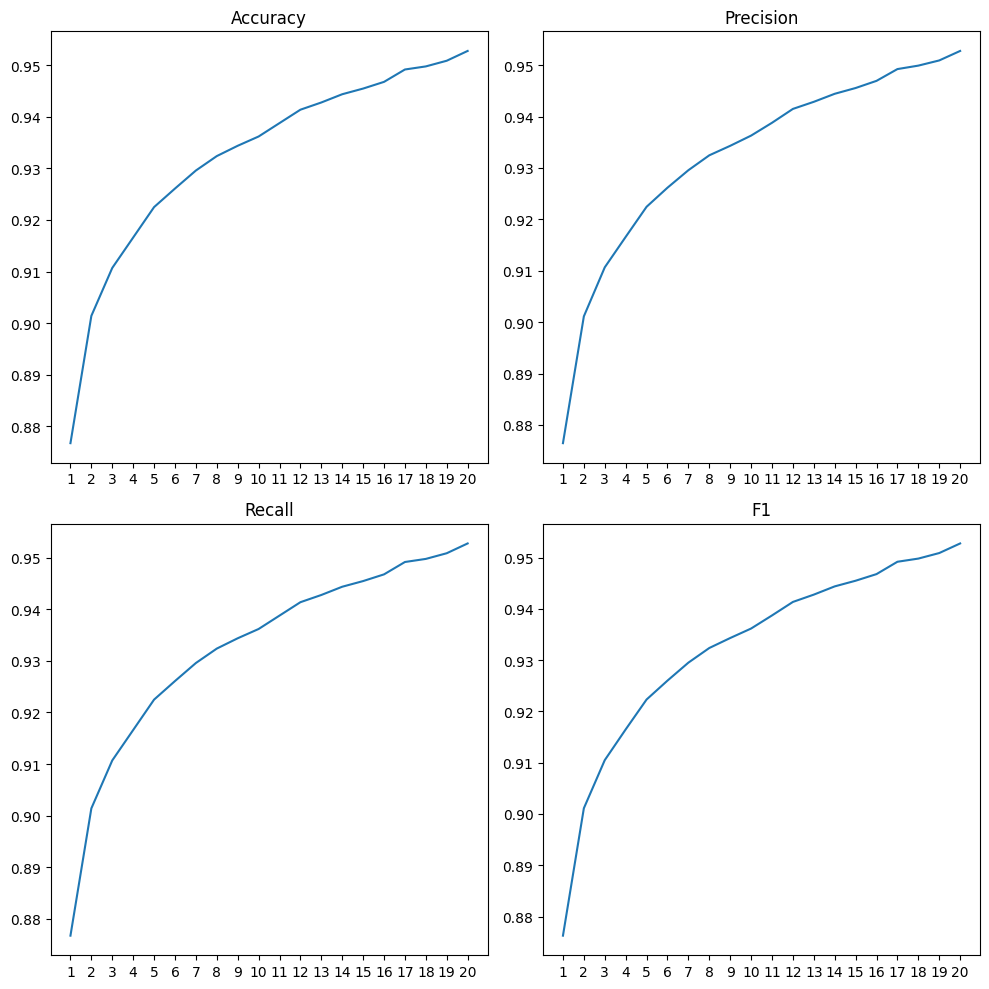

In [33]:
plot_metrics(model_np.metrics)

Afterwards, let's visualize the first 20 predictions with their confidence scores.

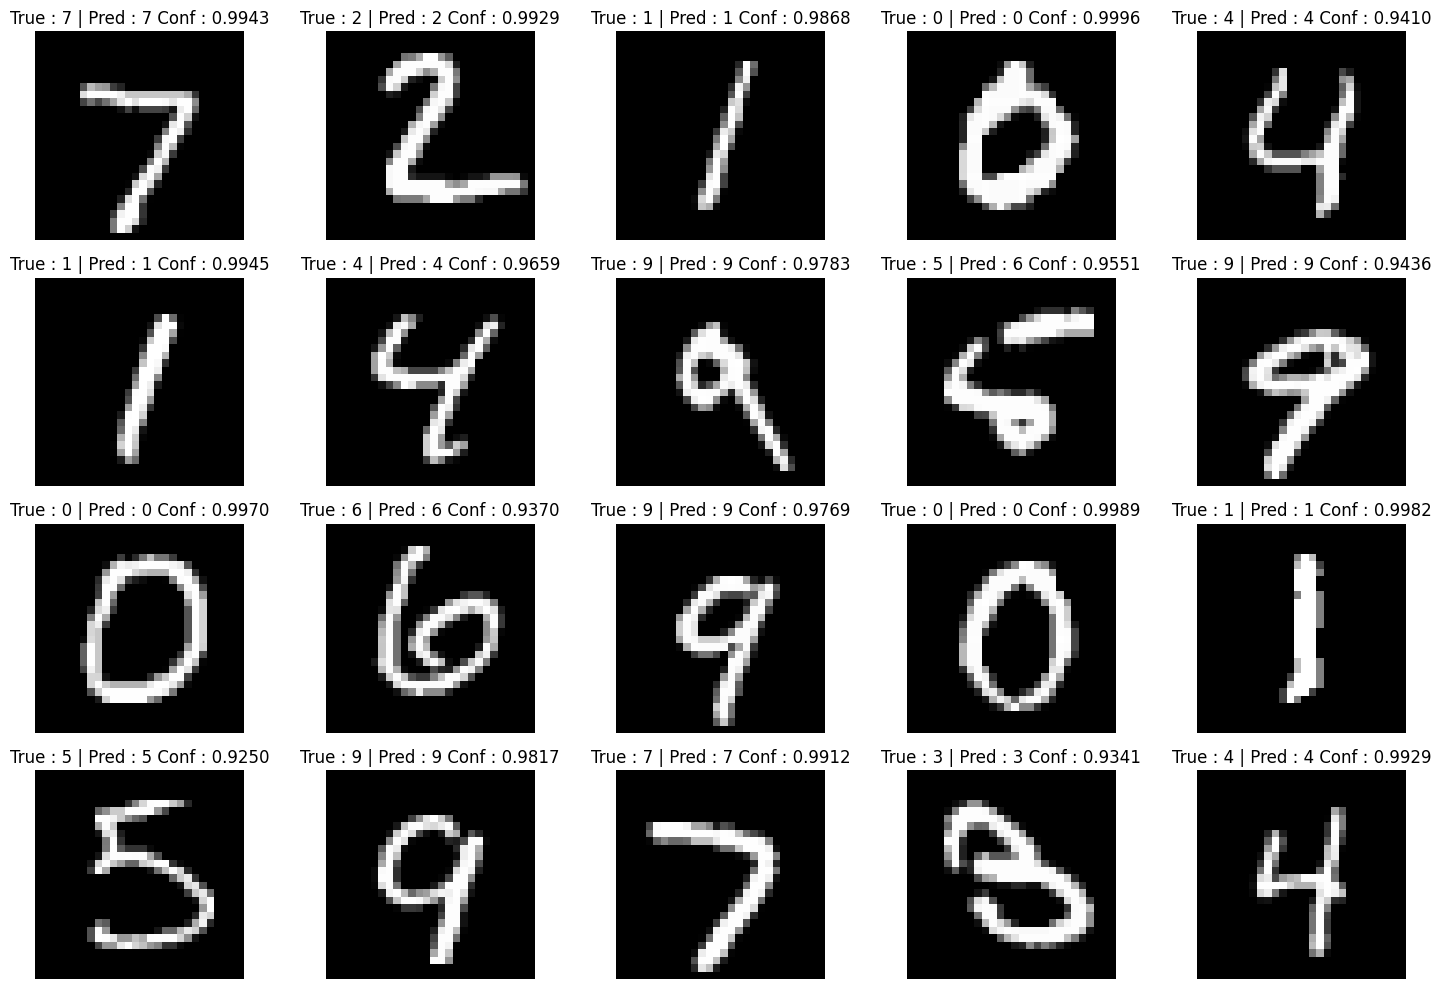

In [34]:
# Create a figure to display the images
fig, axs = plt.subplots(4, 5 , figsize=(15, 10))

# Flatten to iterate easily
axs = axs.flatten()

# For every record in test dataset
for i, rec in enumerate(X_test):
  # Print it (until the 20th)
  if i < 20:
    model_np.predict_single(axs[i], X_test[i], y_test[i])
  else:
    break  # Exit the loop after printing 20 samples

# Fix overlap and show the plot
fig.tight_layout()
fig.show()

First 20 records' predictions look really good. Now let's find the failed predictions and visualize them instead.

Total incorrect predictions : 447

Count of incorrect predictions for class 0 : 14
Count of incorrect predictions for class 1 : 19
Count of incorrect predictions for class 2 : 53
Count of incorrect predictions for class 3 : 42
Count of incorrect predictions for class 4 : 47
Count of incorrect predictions for class 5 : 60
Count of incorrect predictions for class 6 : 35
Count of incorrect predictions for class 7 : 57
Count of incorrect predictions for class 8 : 56
Count of incorrect predictions for class 9 : 64


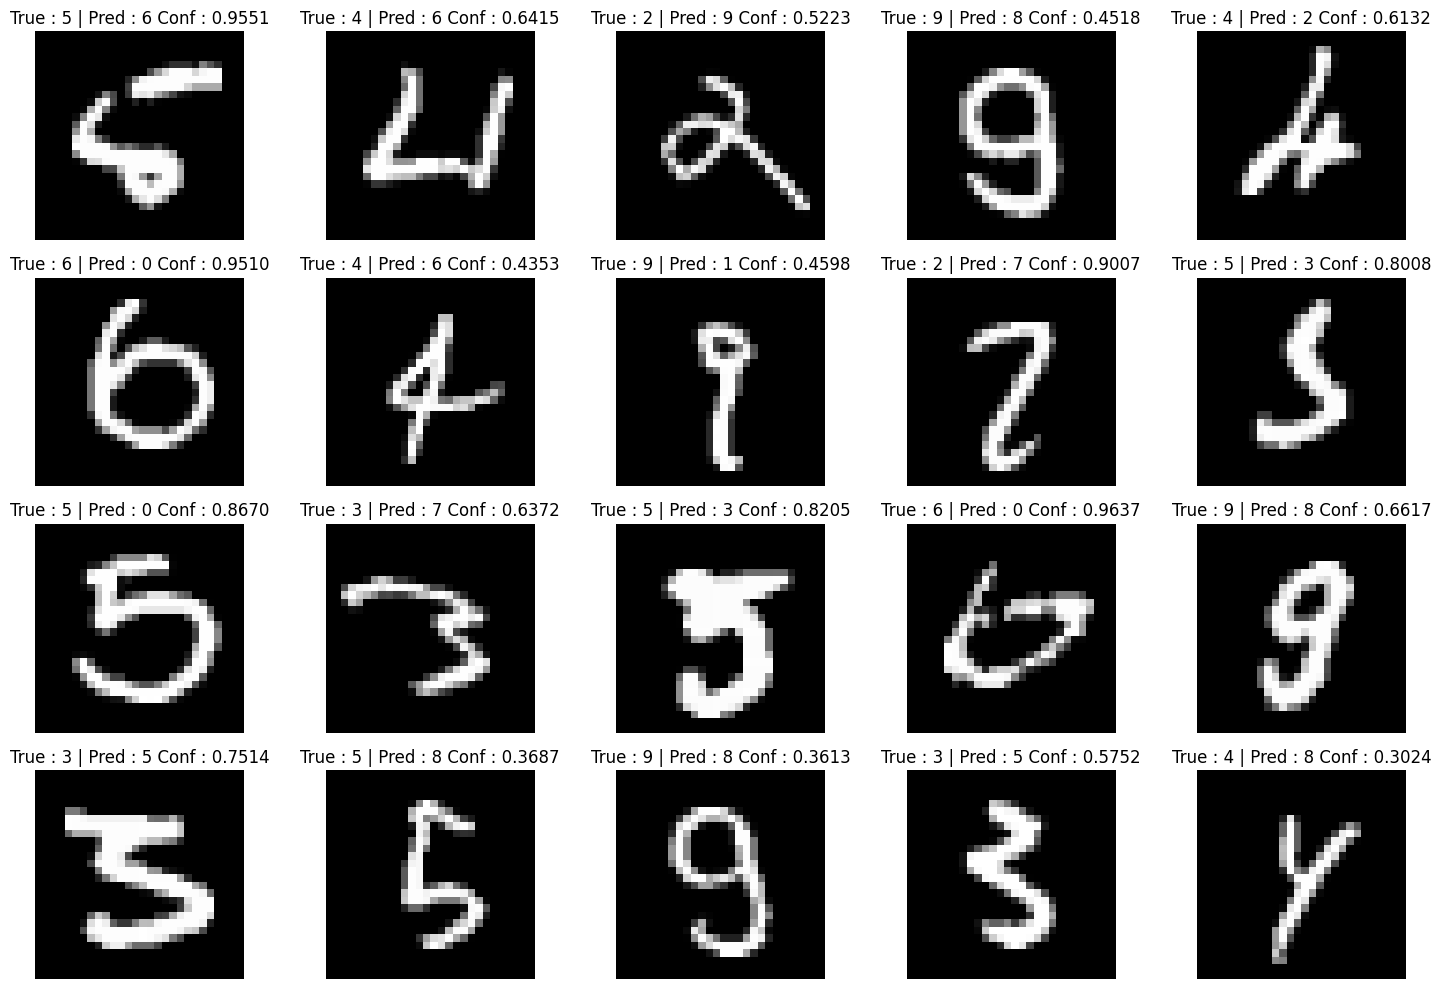

In [35]:
# Get incorrect prediction count
print(f"Total incorrect predictions : {np.not_equal(y_test, test_preds).sum()}\n")

# Count incorrect predictions for each class
incorrect_counts_per_class = np.zeros(output_node_count, dtype=int)
for i in range(len(y_test)): # Iterate over y_test for true labels
    true_label = y_test[i]
    predicted_label = test_preds[i]
    if true_label != predicted_label:
        incorrect_counts_per_class[true_label] += 1

# Print out the incorrect prediction counts
for i, count in enumerate(incorrect_counts_per_class):
    print(f"Count of incorrect predictions for class {i} : {count}")

# Create a figure to display the images
fig, axs = plt.subplots(4, 5 , figsize=(15, 10))

# Flatten to iterate easily
axs = axs.flatten()

# keep failed prediction count
failed_count = 0

# For every test example
for i, rec in enumerate(X_test):
  # Plot if true label and predicted label is different
  if y_test[i] != test_preds[i]: # Compare true label with predicted label
    model_np.predict_single(axs[failed_count], X_test[i], y_test[i])
    failed_count += 1
    # Plot just the first 20
    if failed_count > 19 :
      break;

# Fix overlap and show the plot
fig.tight_layout()
fig.show()

From the incorrect prediction counts per class, it can be inferred that numbers with circles are more prone to guess incorrectly and numbers with distinct shapes (unique to them) are easier for our model to predict. Also, looks like the model is not too confident in most of its incorrect classifications which is good. Lastly, let's create a confusion matrix to automatically create a better visualization than the earlier manual incorrect prediction counts.

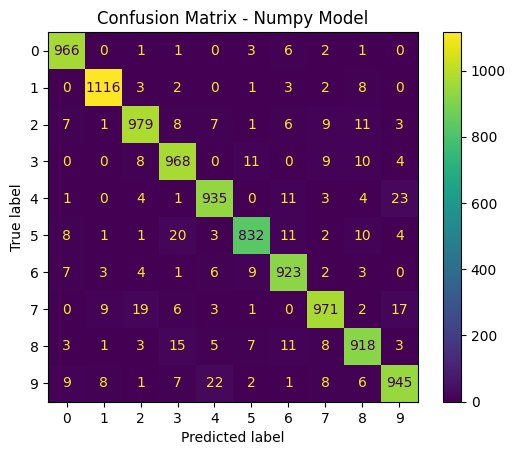

In [36]:
# Create confusion matrix and display it
cm = confusion_matrix(y_test, test_preds, labels=np.arange(output_node_count))
disp = ConfusionMatrixDisplay(cm, display_labels=np.arange(output_node_count))
disp.plot()
plt.title('Confusion Matrix - Numpy Model')
plt.show()

Once again it can be seen that our model predicts correctly most of the time.
# 7 - PyTorch Comparison
Finally, my job with the handmade Neural Network is done. This means that I can just use some Python packages (which conveniently make the job a LOT easier for everybody) to create an identical model and compare them.

In [37]:
import torch.nn.init as init

class Model_Torch(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(input_node_count, hidden_node_count),
      nn.ReLU(),
      nn.Linear(hidden_node_count, output_node_count)
    )

    # Apply He initialization explicitly
    for m in self.modules():
        if isinstance(m, nn.Linear):
            init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)

  def forward(self, X) :
    return self.model(X)

After building our model, let's initialize other required components like the loss function.

In [38]:
# Select the device the model will run on
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Number of epochs the model will train for
num_epochs = 20

# Determine batch size
batch_size = 64

# Initialize the model
model_torch = Model_Torch().to(device)

# Initialize Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(model_torch.parameters(), lr=0.01)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float() / 255.0 # Normalize to [0, 1]
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val).float() / 255.0 # Normalize to [0, 1]
y_val_tensor = torch.from_numpy(y_val).long()

X_test_tensor = torch.from_numpy(X_test).float() / 255.0 # Normalize to [0, 1]
y_test_tensor = torch.from_numpy(y_test).long()

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nPyTorch DataLoaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


PyTorch DataLoaders created:
Train batches: 782
Val batches: 157
Test batches: 157


The reason why I initialized Train DataLoader with shuffle on and others off is to prevent the model from learning order bias. Shuffling is not needed in validation or test sets as the model won't be learning from them anyway. They are there for evaluation within training and while predicting after the training.

In [39]:
def train_torch(model_torch, device, num_epochs, train_loader, val_loader) :
  # Store training epoch and val losses
  train_losses = []
  val_losses = []
  metrics = {}
  metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1'] = [], [], [], []

  # For every epoch
  for epoch in range(num_epochs) :
    # Put the model to training mode
    model_torch.train()

    # reset epoch loss
    epoch_loss = 0

    # For every batch
    for batch_idx, (x, y) in enumerate(train_loader) :
      # Move the tensors to the selected device
      x, y = x.to(device), y.to(device)

      # Run forward pass
      logits = model_torch.forward(x)

      # Calculate losses
      loss = loss_fn(logits, y)
      epoch_loss += loss.item() * x.size(0)

      # Reset gradients
      optimizer.zero_grad()

      # Perform Backpropagation
      loss.backward()

      # Update weights
      optimizer.step()

    # Calculate epoch loss by dividing total loss by the number of batches
    epoch_loss = epoch_loss / (len(train_loader.dataset))
    train_losses.append(epoch_loss)

    # VALIDATION
    # Reset validation loss
    val_loss = 0

    all_preds = []
    all_true_labels = []

    # No gradient calculation in validation
    with torch.no_grad():
      # Put the model to evaluation mode
      model_torch.eval()

      for batch_idx, (x, y) in enumerate(val_loader) :
        # Move the tensors to the selected device
        x, y = x.to(device), y.to(device)

        # Run forward pass
        logits = model_torch.forward(x)

        # Calculate batch and total loss
        loss = loss_fn(logits, y)
        val_loss += loss.item()

        preds = torch.argmax(logits, dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_true_labels.extend(y.cpu().numpy())

      metrics['accuracy'].append(accuracy_score(all_true_labels, all_preds))
      metrics['precision'].append(precision_score(all_true_labels, all_preds, average='weighted', zero_division=0))
      metrics['recall'].append(recall_score(all_true_labels, all_preds, average='weighted', zero_division=0))
      metrics['f1'].append(f1_score(all_true_labels, all_preds, average='weighted', zero_division=0))

    # Calculate val loss by dividing total loss by batch amount
    val_loss = val_loss / (len(val_loader))
    val_losses.append(val_loss)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[epoch]:.4f}, Val Loss: {val_losses[epoch]:.4f}, Acc: {metrics['accuracy'][epoch]:.4f}, Prec: {metrics['precision'][epoch]:.4f}, Rec: {metrics['recall'][epoch]:.4f}, F1: {metrics['f1'][epoch]:.4f}")
  return train_losses, val_losses, metrics

In [40]:
# Record time while training the PyTorch model
start_time_torch = time.perf_counter()
train_losses, val_losses, metrics = train_torch(model_torch, device, num_epochs, train_loader, val_loader)
end_time_torch = time.perf_counter()

duration_torch = end_time_torch - start_time_torch
minutes_torch = int(duration_torch // 60)
seconds_torch = int(duration_torch % 60)
pt_train_time_var = f"{minutes_torch}m {seconds_torch}s"
print(f"PyTorch Model Training Wall time: {pt_train_time_var}")

Epoch 1/20, Train Loss: 0.8585, Val Loss: 0.4854, Acc: 0.8772, Prec: 0.8781, Rec: 0.8772, F1: 0.8767
Epoch 2/20, Train Loss: 0.4210, Val Loss: 0.3748, Acc: 0.8984, Prec: 0.8984, Rec: 0.8984, F1: 0.8979
Epoch 3/20, Train Loss: 0.3542, Val Loss: 0.3309, Acc: 0.9072, Prec: 0.9070, Rec: 0.9072, F1: 0.9069
Epoch 4/20, Train Loss: 0.3203, Val Loss: 0.3035, Acc: 0.9148, Prec: 0.9148, Rec: 0.9148, F1: 0.9147
Epoch 5/20, Train Loss: 0.2970, Val Loss: 0.2853, Acc: 0.9191, Prec: 0.9190, Rec: 0.9191, F1: 0.9189
Epoch 6/20, Train Loss: 0.2791, Val Loss: 0.2706, Acc: 0.9243, Prec: 0.9245, Rec: 0.9243, F1: 0.9243
Epoch 7/20, Train Loss: 0.2644, Val Loss: 0.2570, Acc: 0.9265, Prec: 0.9266, Rec: 0.9265, F1: 0.9264
Epoch 8/20, Train Loss: 0.2515, Val Loss: 0.2476, Acc: 0.9293, Prec: 0.9294, Rec: 0.9293, F1: 0.9292
Epoch 9/20, Train Loss: 0.2400, Val Loss: 0.2352, Acc: 0.9330, Prec: 0.9329, Rec: 0.9330, F1: 0.9329
Epoch 10/20, Train Loss: 0.2297, Val Loss: 0.2274, Acc: 0.9351, Prec: 0.9352, Rec: 0.9351, 

**PyTorch** model training is also done identically. Turns out the **PyTorch** model's training takes less time than the **Numpy** model's and this is a very small model compared to an average production ready model. It is time to run predictions on the test set.

In [41]:
# Store test metrics
test_metrics = {}
all_test_preds = []
all_true_labels = []

with torch.no_grad() :
  for i, (x_batch, y_batch) in enumerate(test_loader) :
    # Run forward pass on a batch
    logits = model_torch(x_batch)
    # Convert to predicted classes. Use torch.argmax with dim=1 and convert to list.
    preds = torch.argmax(logits, dim=1).cpu().tolist()

    # Collect all preds and true labels
    all_test_preds.extend(preds)
    all_true_labels.extend(y_batch.cpu().tolist())

  # Calculate metrics over the test set
  test_metrics['accuracy'] = accuracy_score(all_true_labels, all_test_preds)
  test_metrics['precision'] = precision_score(all_true_labels, all_test_preds, average='weighted', zero_division=0)
  test_metrics['recall'] = recall_score(all_true_labels, all_test_preds, average='weighted', zero_division=0)
  test_metrics['f1'] = f1_score(all_true_labels, all_test_preds, average='weighted', zero_division=0)

  # Print metrics
  for key, value in test_metrics.items() :
    print(f"{key} : {value:.4f}")

accuracy : 0.9534
precision : 0.9534
recall : 0.9534
f1 : 0.9534


Let's plot losses for the **PyTorch** model.

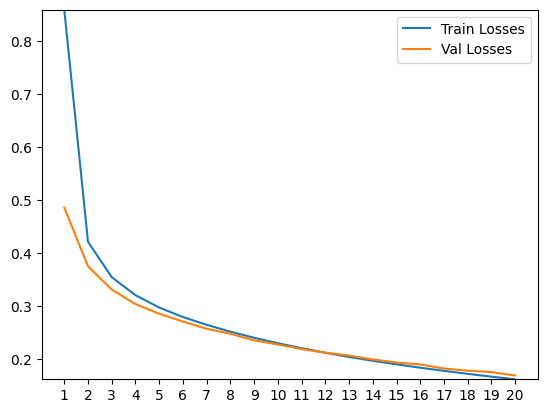

In [42]:
plot_losses(train_losses, val_losses)

Now let's plot the evaluation metrics.

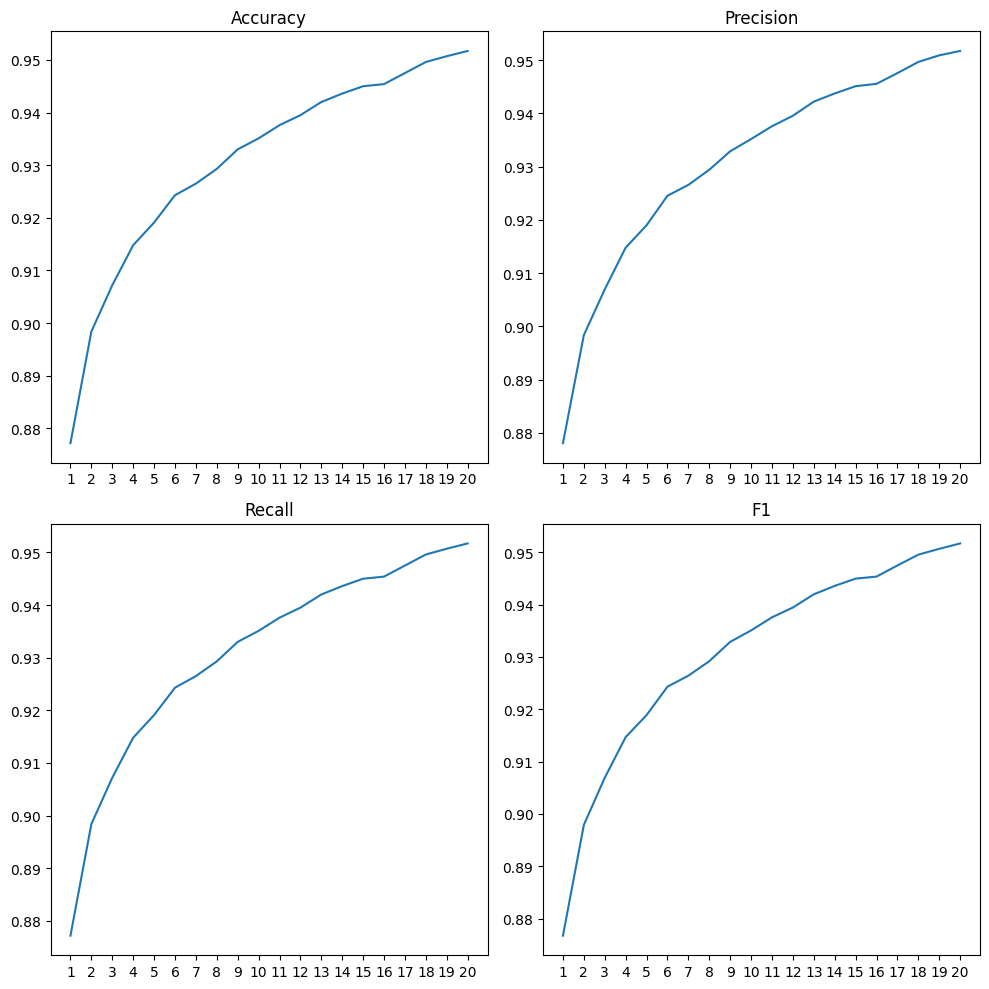

In [43]:
# Print out metrics
plot_metrics(metrics)

Both models' last performances look similar but PyTorch model's metrics zig-zag a ton which is not good. From a different perspective, this means that the model converges really early for this specific example so the remaining epochs are just not needed. (This can be prevented with early stopping very easily). Now how about plotting the first 20 predictions and some incorrect classifications after?

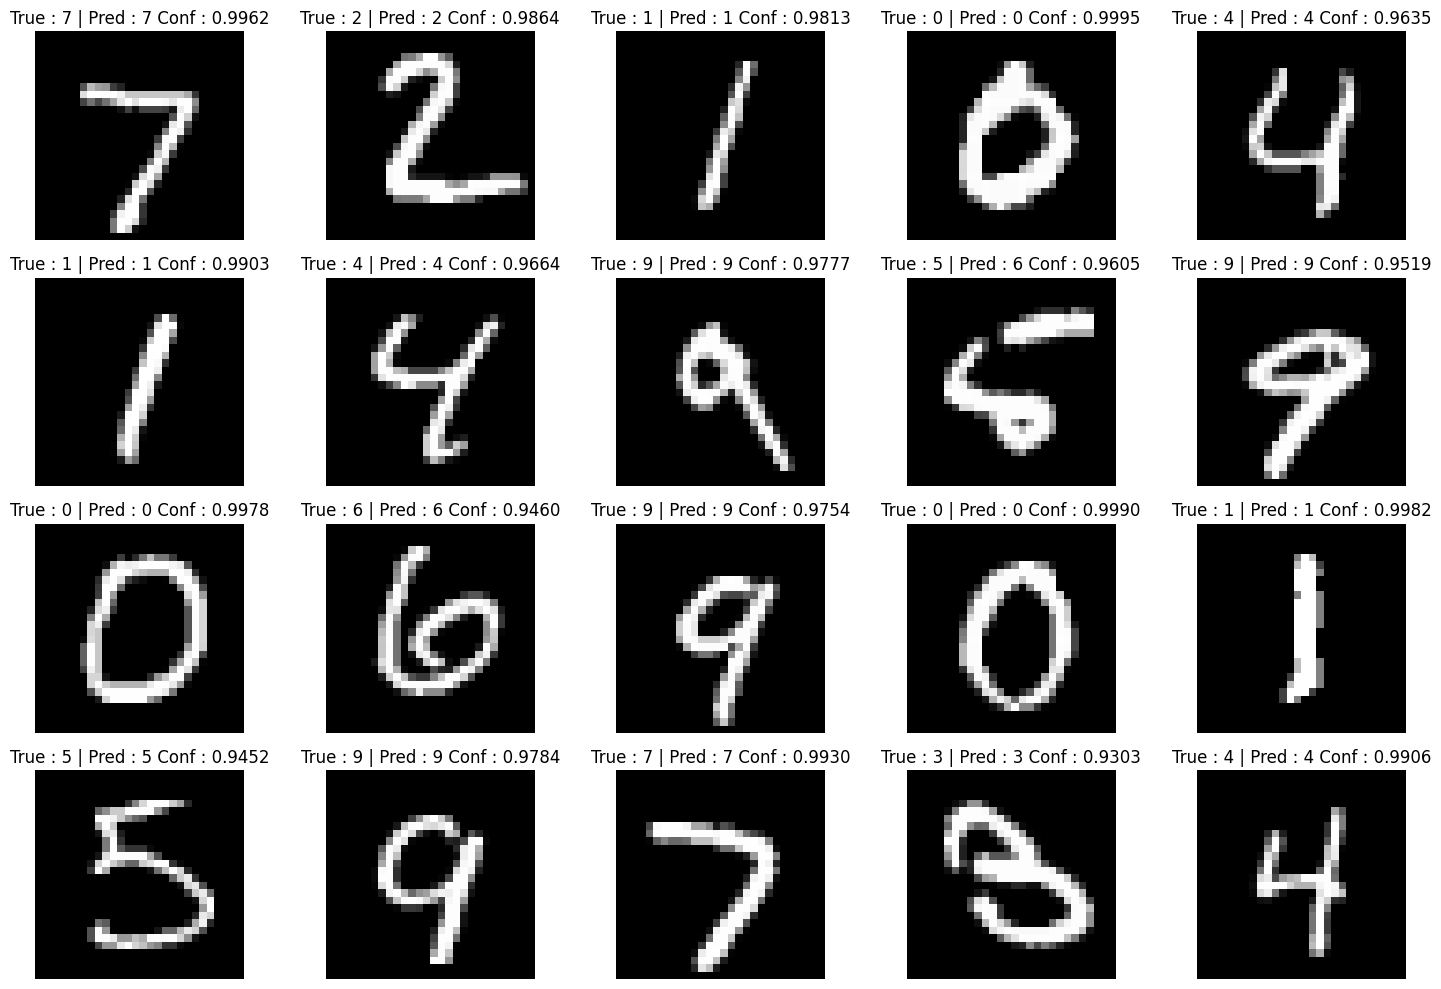

In [44]:
# Create a figure to display the images
fig, axs = plt.subplots(4, 5 , figsize=(15, 10))

# Flatten to iterate easily
axs = axs.flatten()

# For every record in test dataset
for i, (image, label) in enumerate(test_loader.dataset):
  # Print it (until the 20th)
  if i < 20:
    # Add a batch dimension to the image
    image = image.unsqueeze(0)
    # Run forward pass on a sample
    predictions = model_torch(image)
    # Take the highest prediction value
    pred_label = np.argmax(predictions.detach().numpy(), axis=1)
    # Need to use softmax here because it is not built into the model like the numpy one
    confidence_score = np.max(softmax(predictions.detach().numpy()))
    # Show the image along with the predictions
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].set_title(f"True : {label} | Pred : {pred_label[0]} Conf : {confidence_score:.4f}")
    axs[i].axis('off')
  else:
    break  # Exit the loop after printing 20 samples

# Fix overlap and show the plot
fig.tight_layout()
fig.show()

These confidence scores are very close to 1 which is great for correct classifications.

Total incorrect predictions : 466

Count of incorrect predictions for class 0 : 14
Count of incorrect predictions for class 1 : 22
Count of incorrect predictions for class 2 : 46
Count of incorrect predictions for class 3 : 55
Count of incorrect predictions for class 4 : 47
Count of incorrect predictions for class 5 : 58
Count of incorrect predictions for class 6 : 36
Count of incorrect predictions for class 7 : 62
Count of incorrect predictions for class 8 : 58
Count of incorrect predictions for class 9 : 68


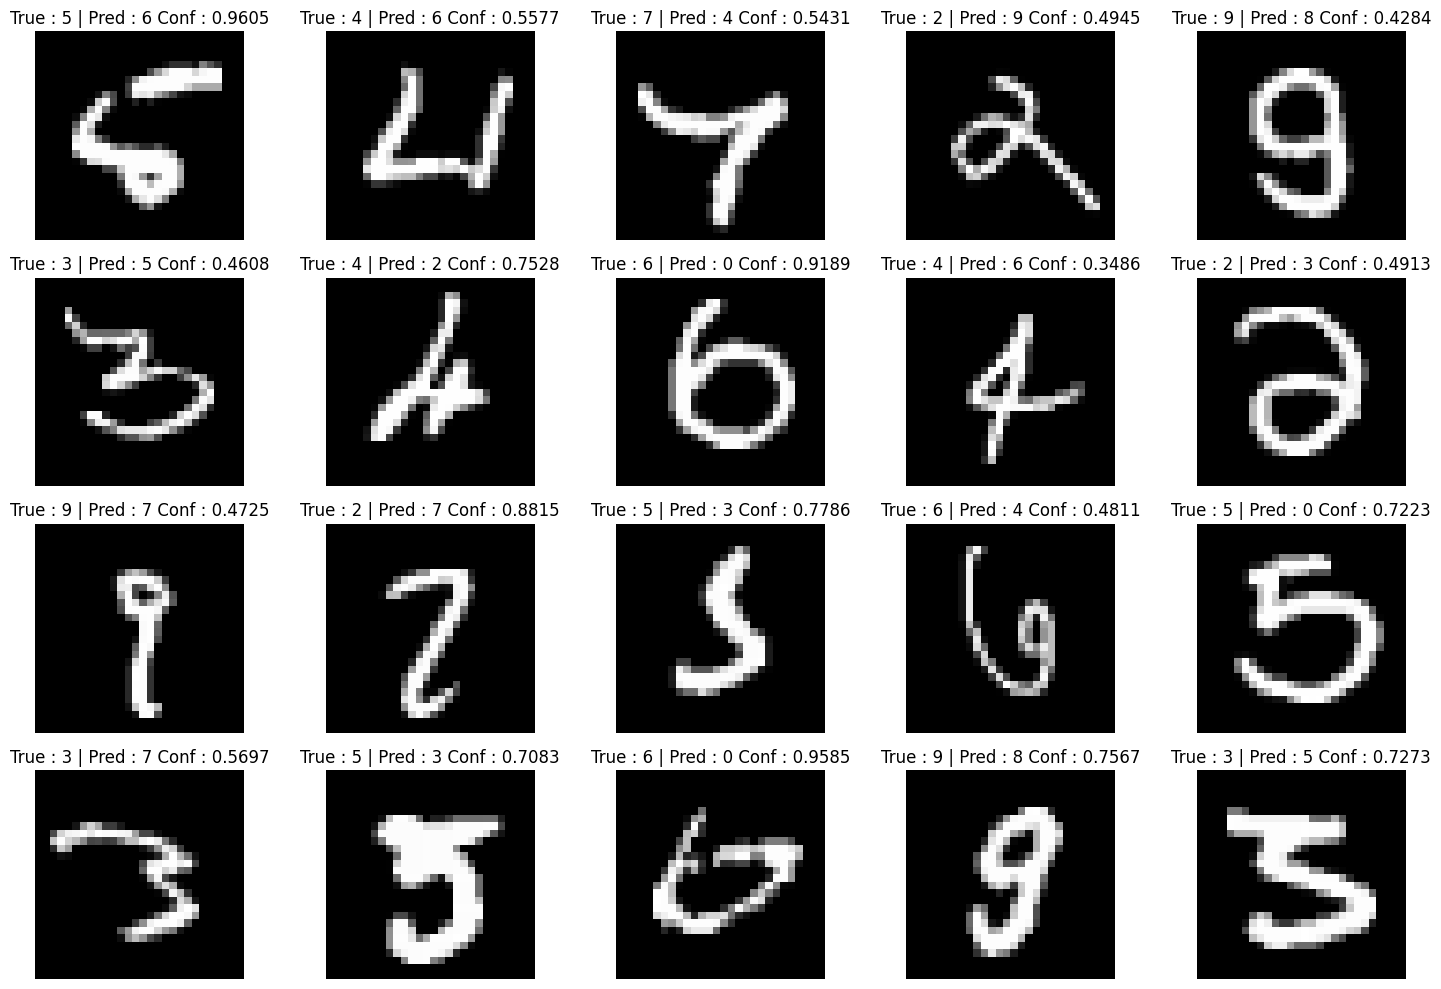

In [45]:
# Get incorrect prediction count
print(f"Total incorrect predictions : {np.not_equal(all_true_labels, all_test_preds).sum()}\n")

# Count incorrect predictions for each class
incorrect_counts_per_class = np.zeros(output_node_count, dtype=int)
for i in range(len(all_true_labels)): # Iterate over y_test for true labels
    true_label = all_true_labels[i]
    predicted_label = all_test_preds[i]
    if true_label != predicted_label:
        incorrect_counts_per_class[true_label] += 1

# Print out the incorrect prediction counts
for i, count in enumerate(incorrect_counts_per_class):
    print(f"Count of incorrect predictions for class {i} : {count}")

# Create a figure to display the images
fig, axs = plt.subplots(4, 5 , figsize=(15, 10))

# Flatten to iterate easily
axs = axs.flatten()

# keep failed prediction count
failed_count = 0

# Get indices of incorrect predictions
incorrect_indices = np.where(np.not_equal(all_true_labels, all_test_preds))[0]

# For every test example that was incorrectly predicted
for idx in incorrect_indices :
  if failed_count >= 20 : # Plot just the first 20
    break

  # Retrieve the image and true label from the test_dataset
  image, true_label_val = test_loader.dataset[idx]

  # Prepare image for PyTorch model (add batch dim, move to device)
  image_for_model = image.unsqueeze(0).to(device)

  # Run forward pass on the single incorrect sample
  with torch.no_grad():
      logits = model_torch(image_for_model)
      predictions_prob = F.softmax(logits, dim=1) # Apply softmax to get probabilities
      predicted_label = torch.argmax(logits, dim=1).item()
      confidence_score = torch.max(predictions_prob).item()

  # Plot on the current subplot axis
  axs[failed_count].imshow(image.squeeze().cpu().numpy(), cmap='gray') # Ensure image is on CPU and is a numpy array
  axs[failed_count].set_title(f"True : {true_label_val} | Pred : {predicted_label} Conf : {confidence_score:.4f}")
  axs[failed_count].axis('off')

  failed_count += 1

# Fix overlap and show the plot
fig.tight_layout()
fig.show()

Just like the **Numpy** model most of the incorrect classifications' confidence scores are not like the correct classifications' scores which is great. For the last visualization, let's go for the confusion matrix.

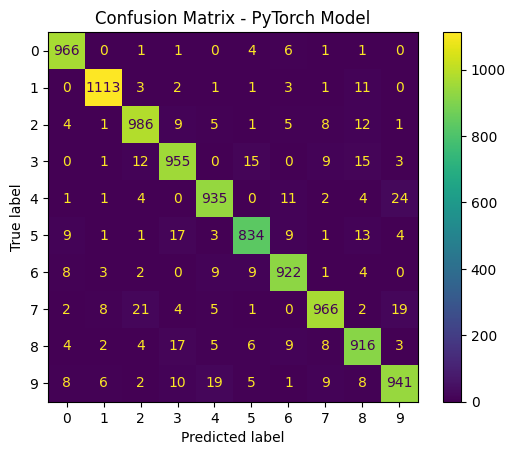

In [46]:
# Create confusion matrix and display it
cm_torch = confusion_matrix(all_true_labels, all_test_preds, labels=np.arange(output_node_count))
disp_torch = ConfusionMatrixDisplay(cm_torch, display_labels=np.arange(output_node_count))
disp_torch.plot()
plt.title('Confusion Matrix - PyTorch Model')
plt.show()

Most of the images were classified correctly here as well. Even better than the **Numpy** model in fact. With that, let's create a simple comparison table for the verdict.

In [47]:
import pandas as pd

# Extract metrics for NumPy model
np_accuracy = model_np.metrics['accuracy'][-1]
np_precision = model_np.metrics['precision'][-1]
np_recall = model_np.metrics['recall'][-1]
np_f1 = model_np.metrics['f1'][-1]

# Extract metrics for PyTorch model
pt_accuracy = test_metrics['accuracy']
pt_precision = test_metrics['precision']
pt_recall = test_metrics['recall']
pt_f1 = test_metrics['f1']

# Create a DataFrame for comparison
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time'],
    'NumPy Model': [f'{np_accuracy:.4f}', f'{np_precision:.4f}', f'{np_recall:.4f}', f'{np_f1:.4f}', np_train_time_var],
    'PyTorch Model': [f'{pt_accuracy:.4f}', f'{pt_precision:.4f}', f'{pt_recall:.4f}', f'{pt_f1:.4f}', pt_train_time_var]
}

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df.to_markdown(index=False))

| Metric        | NumPy Model   | PyTorch Model   |
|:--------------|:--------------|:----------------|
| Accuracy      | 0.9528        | 0.9534          |
| Precision     | 0.9528        | 0.9534          |
| Recall        | 0.9528        | 0.9534          |
| F1-Score      | 0.9527        | 0.9534          |
| Training Time | 2m 52s        | 1m 16s          |


# 8 - Key Insights
* Manually creating a simple classification model takes a ton of effort compared to doing it with an average ML package.
* Preprocessing the data to suit the model may be required depending on the models and the data
* Different activation functions are used on different parts of the models.
* Testing mathematical components with dummy data while building them manually is important to check the process.
* There are different initialization strategies that suit different activation functions and using one is better than random initialization.
* Storing intermediate values will be needed for backpropagation in manual model building.
* To go from multiple output probabilities to a digit prediction, **Argmax** function is used. (**Argmax** works with logits as well as with the outputs of **Softmax**).
* Chain Rule can be very intimidating to implement manually without guidance.
* **Cross-Entropy loss** and **Softmax** combined has the advantage of simplifying most calculations on the first step of gradient descent.
* Hyperparameters such as **Learning Rate**, **Batch Size** and **Epoch Amount** change the outcome and the convergence speed directly and they should be tested in diffent configurations.
* ML packages (in most cases) build more optimal models than manual implementations.
* Mini-batching is computationally faster and cheaper than iterating through single samples over and over because of vectorization on calculation processes.
* Shuffling the data per epoch in training is a way to prevent order bias. This is not done on Validation or Testing as they do not update the model.
* Validation is a great way to extract more accurate information from the training loop.
* Normalizing the data to more manageable ranges is done to increase convergence speed.
* Predictions on the test sets that were held out of training represents real-life use of the models.
* The same data split must be used for fair model comparison.
* Validation data should never influence weight updates.
* PyTorch's autograd automatically handles backpropagation.